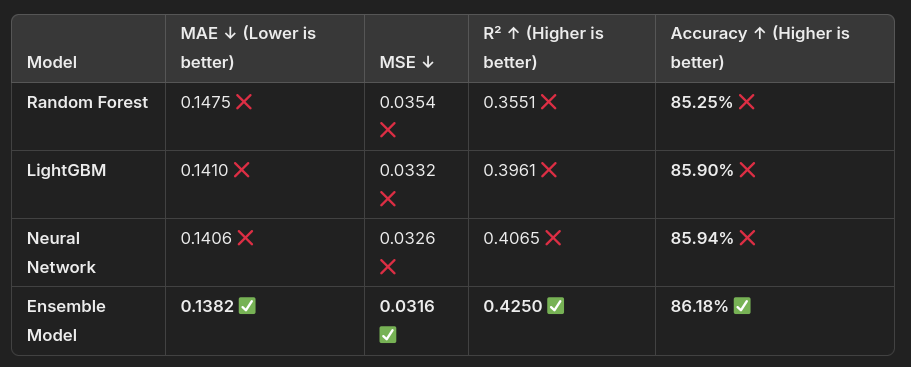

In [17]:
# Find range of actual sentiment scores
y_min, y_max = y_test.min(), y_test.max()
range_y = y_max - y_min  # Range of y_test

# Function to compute regression accuracy
def regression_accuracy(mae, range_y):
    return 1 - (mae / range_y)

# MAE values from your models
mae_values = {
    "Random Forest": 0.1475,
    "LightGBM": 0.1410,
    "Neural Network": 0.1406,
    "Ensemble Model": 0.1382
}

# Compute accuracies
accuracies = {model: regression_accuracy(mae, range_y) for model, mae in mae_values.items()}

# Display results
for model, acc in accuracies.items():
    print(f"{model} Accuracy: {acc:.2%}")


Random Forest Accuracy: 85.25%
LightGBM Accuracy: 85.90%
Neural Network Accuracy: 85.94%
Ensemble Model Accuracy: 86.18%


In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from gensim.models import KeyedVectors`
from sklearn.model_selection import train_test_split

# Load Emoji2Vec model
emoji2vec_model = KeyedVectors.load_word2vec_format("emoji2vec/pre-trained/emoji2vec.bin", binary=True)

# Function to get emoji embeddings
def get_emoji_embedding(emoji):
    try:
        return emoji2vec_model[emoji]
    except KeyError:
        return np.zeros((300,))  # 300D Zero vector for unknown emojis

# Load the full dataset (2700 rows)
df = pd.read_csv("dataset/final_data.csv")  # Change path

# Apply function to convert emojis into embeddings
df["emoji_embedding"] = df["emoji"].apply(get_emoji_embedding)

# Convert to NumPy arrays
X = np.stack(df["emoji_embedding"].values)  # Convert list of arrays to NumPy array
y = df["score"].values  # Sentiment scores

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch Dataset & DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [6]:
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
print("First test emoji embedding shape:", X_test_tensor[0].shape)  # Should be (300,)
print("First test sentiment score:", y_test_tensor[0])


Training samples: 2200
Testing samples: 550
First test emoji embedding shape: torch.Size([300])
First test sentiment score: tensor(0.2500)


# NN MODEL  


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your trained NN model (fix warning)
model = SentimentModel()  # Ensure this matches your saved model architecture
model.load_state_dict(torch.load("model/only_emoji_NN_200.pth", 
                                 map_location=torch.device("cpu"), 
                                 weights_only=True))  # ✅ Fix here
model.eval()  # Set model to evaluation mode


# Lists to store true labels & predictions
y_true, y_pred = [], []

# Disable gradient calculations for inference
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()  # Forward pass
        y_true.extend(y_batch.numpy())  # Store true values
        y_pred.extend(outputs.numpy())  # Store predictions

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print results
print("🔹 NN Model Evaluation:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


🔹 NN Model Evaluation:
MAE: 0.1406
MSE: 0.0326
R² Score: 0.4065


# RF AND LGBM

In [10]:
import joblib

# Load pre-trained models
rf_model = joblib.load("model/only_emoji_RFR.pkl")
lgbm_model = joblib.load("model/only_emoji_LGBM.pkl")

# Make predictions
rf_pred = rf_model.predict(X_test)
lgbm_pred = lgbm_model.predict(X_test)

# Compute metrics for each model
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n🔹 {model_name} Evaluation:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Compare models
evaluate_model(y_true, rf_pred, "Random Forest")
evaluate_model(y_true, lgbm_pred, "LightGBM")



🔹 Random Forest Evaluation:
MAE: 0.1475
MSE: 0.0354
R² Score: 0.3551

🔹 LightGBM Evaluation:
MAE: 0.1410
MSE: 0.0332
R² Score: 0.3961


# ensemble 
# rf, lgbm, xgb

In [11]:
import joblib

# Load ensemble model
ensemble_model = joblib.load("model/only_emoji_ensemble.pkl")


In [13]:
print(type(ensemble_model))
print(ensemble_model)  # Print the actual content


<class 'tuple'>
(RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42), LGBMRegressor(max_depth=5, random_state=42), XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...))


In [14]:
import joblib

# Load the tuple file
rf_model, lgbm_model, xgb_model = joblib.load("model/ensemble_tuple.pkl")

# Verify models are loaded correctly
print(type(rf_model))  # Should be <class 'sklearn.ensemble._forest.RandomForestRegressor'>
print(type(lgbm_model))  # Should be <class 'lightgbm.sklearn.LGBMRegressor'>
print(type(xgb_model))  # Should be <class 'xgboost.sklearn.XGBRegressor'>


<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>


In [15]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge  # Meta-model

# Define stacking ensemble
stacking_ensemble = StackingRegressor(
    estimators=[
        ("rf", rf_model), 
        ("lgbm", lgbm_model), 
        ("xgb", xgb_model)
    ],
    final_estimator=Ridge(),  # Meta-model to combine predictions
    passthrough=True
)

# Train the ensemble
stacking_ensemble.fit(X_train, y_train)

# Save new ensemble model
joblib.dump(stacking_ensemble, "stacking_ensemble.pkl")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 300
[LightGBM] [Info] Start training from score 0.638068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

['stacking_ensemble.pkl']

In [16]:
# Load model
ensemble_model = joblib.load("model/stacking_ensemble.pkl")  # or "voting_ensemble.pkl"

# Predict
y_pred = ensemble_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("🔹 Ensemble Model Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")


🔹 Ensemble Model Performance:
MAE: 0.1382
MSE: 0.0316
R² Score: 0.4250
